In [5]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from glob import glob

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

print(tf.__version__)

2.1.0


In [6]:
image_path = '../data/HAM10000'
image_path

'../data/HAM10000'

In [7]:
# From https://www.kaggle.com/elvinj1203/resnet50-84-test-acc
data=pd.read_csv("../data/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [8]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.2, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [10]:
train.head()

,image_full_name,lesion_id,dx
482,ISIC_0030346.jpg,HAM_0005146,bkl
7123,ISIC_0032007.jpg,HAM_0007477,nv
6581,ISIC_0030449.jpg,HAM_0007071,nv
6991,ISIC_0025812.jpg,HAM_0001767,nv
6333,ISIC_0027587.jpg,HAM_0003907,nv


In [11]:
"""image_full_name 	lesion_id 	dx
482 	ISIC_0030346.jpg 	HAM_0005146 	bkl
7123 	ISIC_0032007.jpg 	HAM_0007477 	nv
6581 	ISIC_0030449.jpg 	HAM_0007071 	nv
6991 	ISIC_0025812.jpg 	HAM_0001767 	nv
6333 	ISIC_0027587.jpg 	HAM_0003907 	nv"""

'image_full_name \tlesion_id \tdx\n482 \tISIC_0030346.jpg \tHAM_0005146 \tbkl\n7123 \tISIC_0032007.jpg \tHAM_0007477 \tnv\n6581 \tISIC_0030449.jpg \tHAM_0007071 \tnv\n6991 \tISIC_0025812.jpg \tHAM_0001767 \tnv\n6333 \tISIC_0027587.jpg \tHAM_0003907 \tnv'

In [12]:
val.dx.value_counts()

nv       1317
bkl       243
mel       230
bcc       111
akiec      57
vasc       27
df         18
Name: dx, dtype: int64

In [13]:
test.dx.value_counts()

nv       1338
bkl       228
mel       226
bcc        93
akiec      69
df         28
vasc       21
Name: dx, dtype: int64

In [14]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# horizontal_flip=True to flip images randomly
image_generator = ImageDataGenerator(
    rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE_128 = (128, 128)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test,
    directory=image_path,
    x_col="image_full_name", # x_col = file name
    y_col="dx",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE_128)
)

Found 6009 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [16]:
def MobileNetV2_frozen(img_size=None):
  # Import the mobilenetV2 model and discards the last 1000 neuron layer.
  base_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=img_size) 
  base_model.trainable = False
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # Dense = FullyConnected
  x = Dense(1024,activation='relu')(x) 
  # Final layer with softmax activation
  pred_layer = Dense(7, activation='softmax')(x) 

  model = Model(inputs=base_model.input,outputs=pred_layer)
  return model


In [17]:
model = MobileNetV2_frozen((128,128,3))
model.summary()

# Adam learning rate
#opt = Adam(lr=0.001)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 8, 8, 64)     12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 8, 8, 64)     256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 8, 8, 384)    24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 8, 8, 384)    1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 8, 8, 384)    0           block_7_expand_BN[0][0]    

In [19]:
mobileNetV2_frozen_path = "mobileNetV2_frozen-cp-{epoch:04d}.ckpt"
mobileNetV2_frozen_dir = '../models' + mobileNetV2_frozen_path

In [20]:
saveCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=mobileNetV2_frozen_dir, 
    verbose=1, 
    save_weights_only=True,
    period=5)

In [21]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[saveCheckpoint]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 188 steps, validate for 63 steps
Epoch 1/10
188/188 [==============================] - 627s 3s/step - loss: 0.8553 - accuracy: 0.7241 - val_loss: 1.9419 - val_accuracy: 0.6575
Epoch 2/10
188/188 [==============================] - 86s 458ms/step - loss: 0.4966 - accuracy: 0.8178 - val_loss: 2.2859 - val_accuracy: 0.6575
Epoch 3/10
188/188 [==============================] - 96s 512ms/step - loss: 0.3026 - accuracy: 0.8918 - val_loss: 2.7956 - val_accuracy: 0.6570
Epoch 4/10
188/188 [==============================] - 91s 485ms/step - loss: 0.1294 - accuracy: 0.9662 - val_loss: 2.5997 - val_accuracy: 0.6415
Epoch 5/10
187/188 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9941
Epoch 00005: saving model to ../modelsmobileNetV2_frozen-cp-0005.ckpt
188/188 [==============================] - 94s 500ms/step - loss: 0.0455 - accuracy: 0.9942 - val_loss: 3.8060 - val_accuracy: 0.6565
Epoch 6/10
188/188 [=========

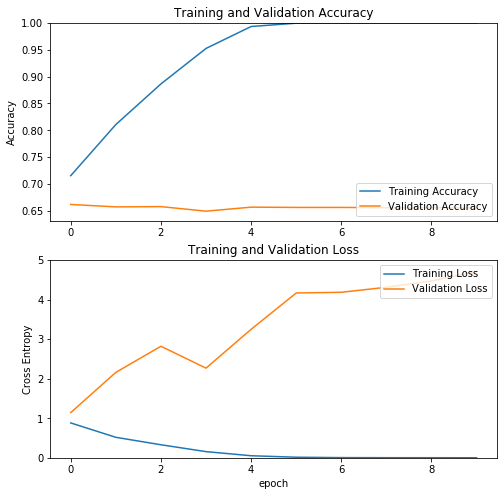

In [22]:
history = {
    'accuracy': [0.7156, 0.8108, 0.8864, 0.9525, 0.9933, 0.9995, 1, 1, 1, 1],
    'loss': [0.8822, 0.5182, 0.33, 0.1562, 0.0521, 0.0147, 0.0048, 0.0028, 0.0021, 0.0016],
    'val_accuracy' : [0.662, 0.6575, 0.658, 0.6495, 0.657, 0.6565, 0.6565, 0.6560, 0.6560, 0.6555],
    'val_loss' : [1.1430, 2.1611, 2.8211, 2.2683, 3.2497, 4.1685, 4.1867, 4.3136, 4.4738, 4.7158]
}

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()